In [14]:
import os
import pandas as pd


def extract_hota_table(log_file):
    table_data = []
    with open(log_file, 'r') as file:
        lines = file.readlines()
        table_start = False
        for line in lines:
            if line.startswith('HOTA:'):
                table_start = True
                continue
            if table_start and line.strip() != "":
                row_data = line.strip().split()
                table_data.append(row_data)
            if table_start and line.strip() == "":
                break
    headers = ['seq_name', 'HOTA', 'DetA', 'AssA', 'DetRe', 'DetPr',
               'AssRe', 'AssPr', 'LocA', 'OWTA', 'HOTA(0)', 'LocA(0)', 'HOTALocA(0)']
    df = pd.DataFrame(table_data, columns=headers)

    # df = pd.DataFrame(table_data[1:], columns=table_data[0])
    return df


def iterate_run_folders(base_folder):
    comparison_data = []
    run_folders = [folder for folder in os.listdir(
        base_folder) if os.path.isdir(os.path.join(base_folder, folder))]
    print("number of files found", len(run_folders))
    for run_folder in sorted(run_folders):
        run_path = os.path.join(base_folder, run_folder)
        eval_output_path = os.path.join(run_path, 'evaluation_output.txt')

        if os.path.isfile(eval_output_path):
            hota_df = extract_hota_table(eval_output_path)
            try:
                single_metric_for_the_run = hota_df[hota_df.seq_name == 'COMBINED']['HOTA'].astype(
                    float).values[0]
            except Exception as e:
                print(f"error with {eval_output_path}", e)
                single_metric_for_the_run = None

            comparison_data.append({
                'Run Name': run_folder,
                'HOTA Score': single_metric_for_the_run
            })

    comparison_df = pd.DataFrame(comparison_data)
    return comparison_df

In [15]:


base_folder = "MOT20"
comparison_df = iterate_run_folders(base_folder)

comparison_df['Resolution'] = comparison_df['Run Name'].str.extract(
    r'input_(\d+)')[0].astype(int)
comparison_df['Tracker'] = comparison_df['Run Name'].apply(
    lambda x: x.split('__')[0])
comparison_df['Confidence'] = comparison_df['Run Name'].apply(
    lambda x: float(x.split('__')[2].split('_')[1]))
comparison_df

number of files found 4


,Run Name,HOTA Score,Resolution,Tracker,Confidence
0,DeepSORT__input_1280__conf_.25,24.897,1280,DeepSORT,0.25
1,LiteSORT__input_1280__conf_.25,24.896,1280,LiteSORT,0.25
2,SORT__input_1280__conf_.25,20.122,1280,SORT,0.25
3,StrongSORT__input_1280__conf_.25,24.573,1280,StrongSORT,0.25


# Plot FPS from Runtime log


In [24]:
comparison_df

,Run Name,HOTA Score,Resolution,Tracker,Confidence
0,DeepSORT__input_1280__conf_.25,24.897,1280,DeepSORT,0.25
1,LiteSORT__input_1280__conf_.25,24.896,1280,LiteSORT,0.25
2,SORT__input_1280__conf_.25,20.122,1280,SORT,0.25
3,StrongSORT__input_1280__conf_.25,24.573,1280,StrongSORT,0.25


In [3]:
import re
# This pattern captures the resolution, confidence, and the FPS for MOT17-02-FRCNN
pattern = r'Running tracker: (.+) with Input Resolution: (\d+) and Confidence Threshold: ([.\d]+)\n.+MOT20-01\...\ntime: \d+s \| Avg FPS: ([.\d]+)'
log_text = open('fps_mot20.txt', 'r').read()
# Find all matches in the log text
matches = re.findall(pattern, log_text)

# Create a DataFrame from the matches
fps_data = pd.DataFrame(
    matches, columns=['Tracker', 'Resolution', 'Confidence', 'FPS'])

# Convert the types of the columns
fps_data['Resolution'] = fps_data['Resolution'].astype(int)
fps_data['Confidence'] = fps_data['Confidence'].astype(float)
fps_data['FPS'] = fps_data['FPS'].astype(float)
comparison_df = comparison_df.merge(
    fps_data, on=['Tracker', 'Resolution', 'Confidence'], how='left')

In [4]:

comparison_df

,Run Name,HOTA Score,Resolution,Tracker,Confidence,FPS
0,DeepSORT__input_1280__conf_.25,24.897,1280,DeepSORT,0.25,8.9
1,LiteSORT__input_1280__conf_.25,24.896,1280,LiteSORT,0.25,21.1
2,SORT__input_1280__conf_.25,20.122,1280,SORT,0.25,27.3
3,StrongSORT__input_1280__conf_.25,24.573,1280,StrongSORT,0.25,3.8


In [12]:
comparison_df[['Tracker', 'FPS', 'HOTA Score']].sort_values(
    ['FPS', 'HOTA Score'], ascending=[False, True])

,Tracker,FPS,HOTA Score
2,SORT,27.3,20.122
1,LiteSORT,21.1,24.896
0,DeepSORT,8.9,24.897
3,StrongSORT,3.8,24.573


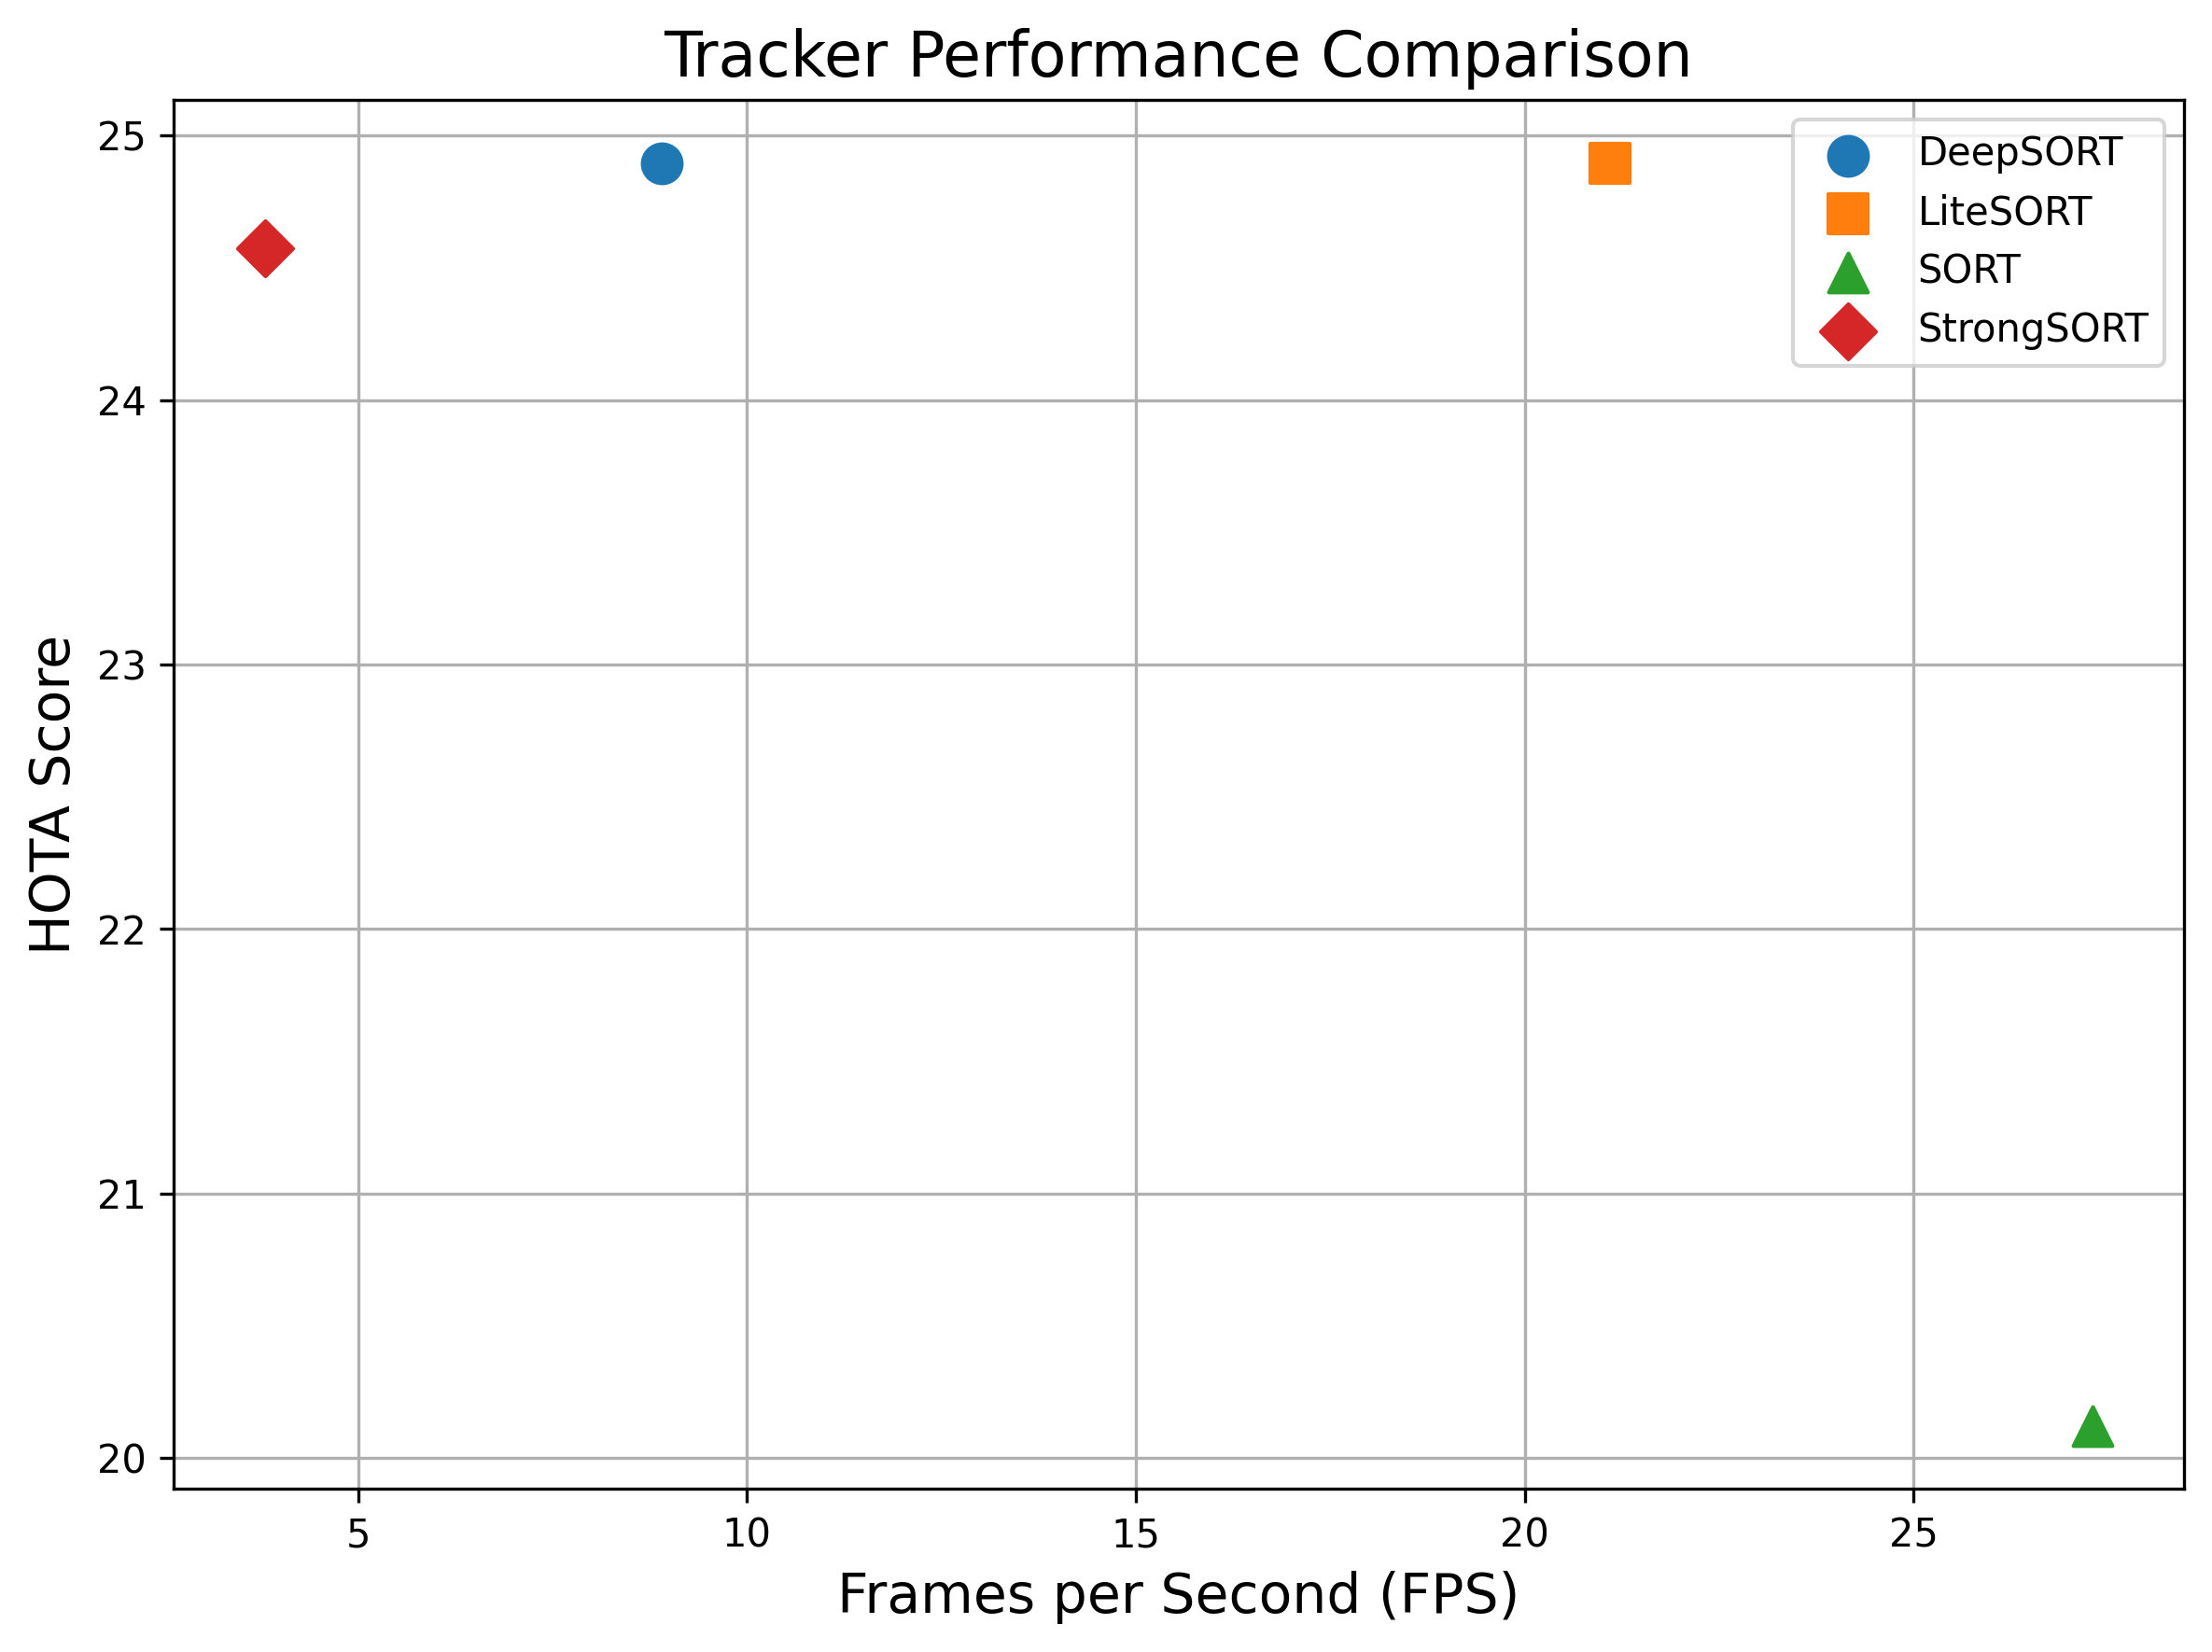

The plot was saved as plots/tracker_performance_comparison.png


In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import os


# Define markers for each tracker for distinction
markers = ['o', 's', '^', 'D']  # Circle, square, triangle up, and diamond

# Create a new figure and axis object
# High-resolution for publication
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)

# Scatter plot with trackers color-coded and different markers
for i, tracker in enumerate(comparison_df['Tracker']):
    ax.scatter(
        comparison_df.loc[comparison_df['Tracker'] == tracker, 'FPS'],
        comparison_df.loc[comparison_df['Tracker'] == tracker, 'HOTA Score'],
        s=100,  # Marker size
        label=tracker,
        marker=markers[i]  # Marker shape
    )

# Labels and Title
ax.set_xlabel('Frames per Second (FPS)', fontsize=14)
ax.set_ylabel('HOTA Score', fontsize=14)
ax.set_title('Tracker Performance Comparison', fontsize=16)

# Aesthetics for CVPR publication
ax.grid(True)
ax.legend()
plt.tight_layout()

# Define the directory for saving plots
plot_dir = 'plots/'

# Create the directory if it doesn't exist
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

# Save the plot in the 'plots/' directory with high quality
plot_path = os.path.join(plot_dir, 'tracker_performance_comparison.png')
plt.savefig(plot_path, format='png', bbox_inches='tight', pad_inches=0.1)

# Show the plot
plt.show()

# Output the path where the plot is saved (useful if running this code locally)
print(f"The plot was saved as {plot_path}")